### 0. 기본 세팅

In [1]:
# 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install xlrd==1.2.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (22.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155335 files and di

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import xlrd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumBarunGothic') 

import warnings
warnings.filterwarnings('ignore')

### 1. 중고거래 데이터 행정동별 집계

In [ ]:
# 크롤링
import time
import os
from bs4 import BeautifulSoup
from selenium.webdriver import Chrome

url = 'https://m.bunjang.co.kr/search/products?q=%EC%84%9C%EC%9A%B8%20%EA%B0%95%EC%84%9C%EA%B5%AC&order=date&page=' + '1'
loc = []
name = []
driver = Chrome(os.path.join('/Users/dhyuni/Downloads/chromedriver'))
driver.get(url)

result = 1

while result:
    for place in range(3, 13):
        time.sleep(1)
        full_html = driver.page_source # 현재 페이지 전체를 가져옴
        soup = BeautifulSoup(full_html, 'html.parser')
        content_list = soup.find_all('div',class_="sc-gmeYpB dDFuXd")
        name_list = soup.find_all('div',class_="sc-cooIXK ljroUG")

        for i in content_list:
            print(i.text)
            loc_i = i.text
            loc.append(loc_i)

        for i in name_list:
            print(i.text)
            name.append(i.text)

        try:
            driver.find_element_by_xpath('//*[@id="root"]/div/div/div[4]/div/div[5]/div/a['+str(place)+']').click()
        except:
            result = 0
trade = pd.DataFrame({"동":loc, "거래물품":name})
trade.to_csv("/Users/dhyuni/Downloads/강서구_중고거래.csv", index=False)

In [2]:
trade = pd.read_csv('/content/drive/Shareddrives/강서구/220319 MakeDF/data/강서구_중고거래.csv')

# 중복 데이터 제거
print("중복 제거 전 : ", len(trade))
trade.drop_duplicates(inplace=True)
print("중복 제거 후 : ", len(trade))

# 동 이름 변경 (제1동 -> 1동)
for i in tqdm(trade.index): 
  try:
    dong = trade['동'][i].split()[2]
    if dong.find('제') != -1: 
      dong = dong.replace('제','')
    if dong in  ['염창동','등촌1동', '등촌2동', '등촌3동', '화곡1동', '화곡2동', '화곡3동', '화곡4동', '화곡본동', '화곡6동', '화곡8동',
         '가양1동', '가양2동', '가양3동', '발산1동', '우장산동', '공항동','방화1동','방화2동','방화3동']:
      trade['동'][i] = dong
    else: trade = trade.drop([i], axis=0)
  except:
    trade = trade.drop([i], axis=0)

trade.reset_index(drop=True, inplace=True)

중복 제거 전 :  30000
중복 제거 후 :  28091


100%|██████████| 28091/28091 [00:17<00:00, 1578.90it/s]


In [3]:
# count
dng = list(set(trade['동']))
cnt = [0]*len(dng)
for i in range(len(dng)):
  cnt[i] = list(trade['동']).count(dng[i])
print(cnt)

[852, 2100, 1322, 919, 1342, 1973, 695, 2418, 1633, 2440, 2915, 1286, 1404, 1729, 920, 1060, 486, 775, 1041, 496]


AttributeError: ignored

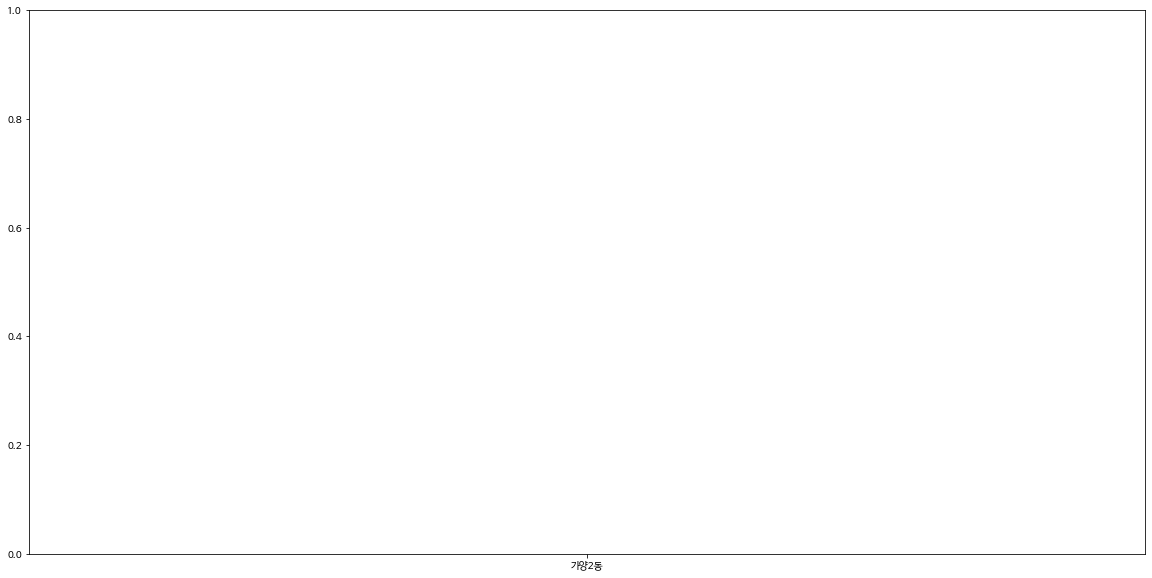

In [10]:
# df 만들기
gs_trade_cnt = pd.DataFrame({"동":dng, "중고거래횟수":cnt})
plt.figure(figsize=(20, 10))
plt.bar(gs_trade_cnt['동'], gs_trade_cnt['중고거래횟수'], palette='Pastel1');

In [ ]:
gs_trade_cnt.to_csv('/content/drive/Shareddrives/강서구/using_data/중고거래.csv', index=False)

### 2. 행정동별 상권 세분화 데이터

In [11]:
# 동단위 서울 코드
code_dong = pd.read_excel("/content/drive/Shareddrives/강서구/220319 MakeDF/data/행정동코드_매핑정보_20200325.xlsx", sheet_name = "행정동코드")
code_dong = code_dong[['통계청행정동코드','행자부행정동코드', '시군구명', '행정동명']].drop([0], axis=0).dropna().drop_duplicates()
code_dong["지역명"] = code_dong['시군구명'] + " " + code_dong["행정동명"]
code_dong["행자부행정동코드"] = code_dong["행자부행정동코드"].astype('int').astype('str')
code_dong

,통계청행정동코드,행자부행정동코드,시군구명,행정동명,지역명
1,1101053.0,11110530,종로구,사직동,종로구 사직동
2,1101054.0,11110540,종로구,삼청동,종로구 삼청동
3,1101055.0,11110550,종로구,부암동,종로구 부암동
4,1101056.0,11110560,종로구,평창동,종로구 평창동
5,1101057.0,11110570,종로구,무악동,종로구 무악동
...,...,...,...,...,...
420,1125070.0,11740690,강동구,둔촌1동,강동구 둔촌1동
421,1125071.0,11740700,강동구,둔촌2동,강동구 둔촌2동
422,1125072.0,11740570,강동구,암사1동,강동구 암사1동
423,1125073.0,11740610,강동구,천호2동,강동구 천호2동


In [12]:
# 상권세분화 데이터
gs_st = pd.read_csv('/content/drive/Shareddrives/강서구/220319 MakeDF/data/상권세분화.csv', header=None)
gs_st.columns = ['블록코드', '행정동코드', '블록유형_대분류', '블록유형_중분류', '블록유형_소분류', '배후지유형_대분류', '배후지유형_중분류', '배후지유형_소분류', '역세권여부', '대학가여부']
gs_st['행정동코드'] = gs_st['행정동코드'].astype('str')
for i in gs_st.index:
  if gs_st['행정동코드'][i].startswith('11500')==False: gs_st.drop([i], axis=0, inplace=True)
gs_st['동'] = [0]*len(gs_st)

# 행정동코드 매핑
for i in gs_st.index:
  code = gs_st['행정동코드'][i]
  idx = list(code_dong['행자부행정동코드']).index(code)
  gs_st['동'][i] = list(code_dong['행정동명'])[idx]
gs_st = gs_st.drop(['블록코드', '행정동코드'], axis=1).reset_index(drop=True)

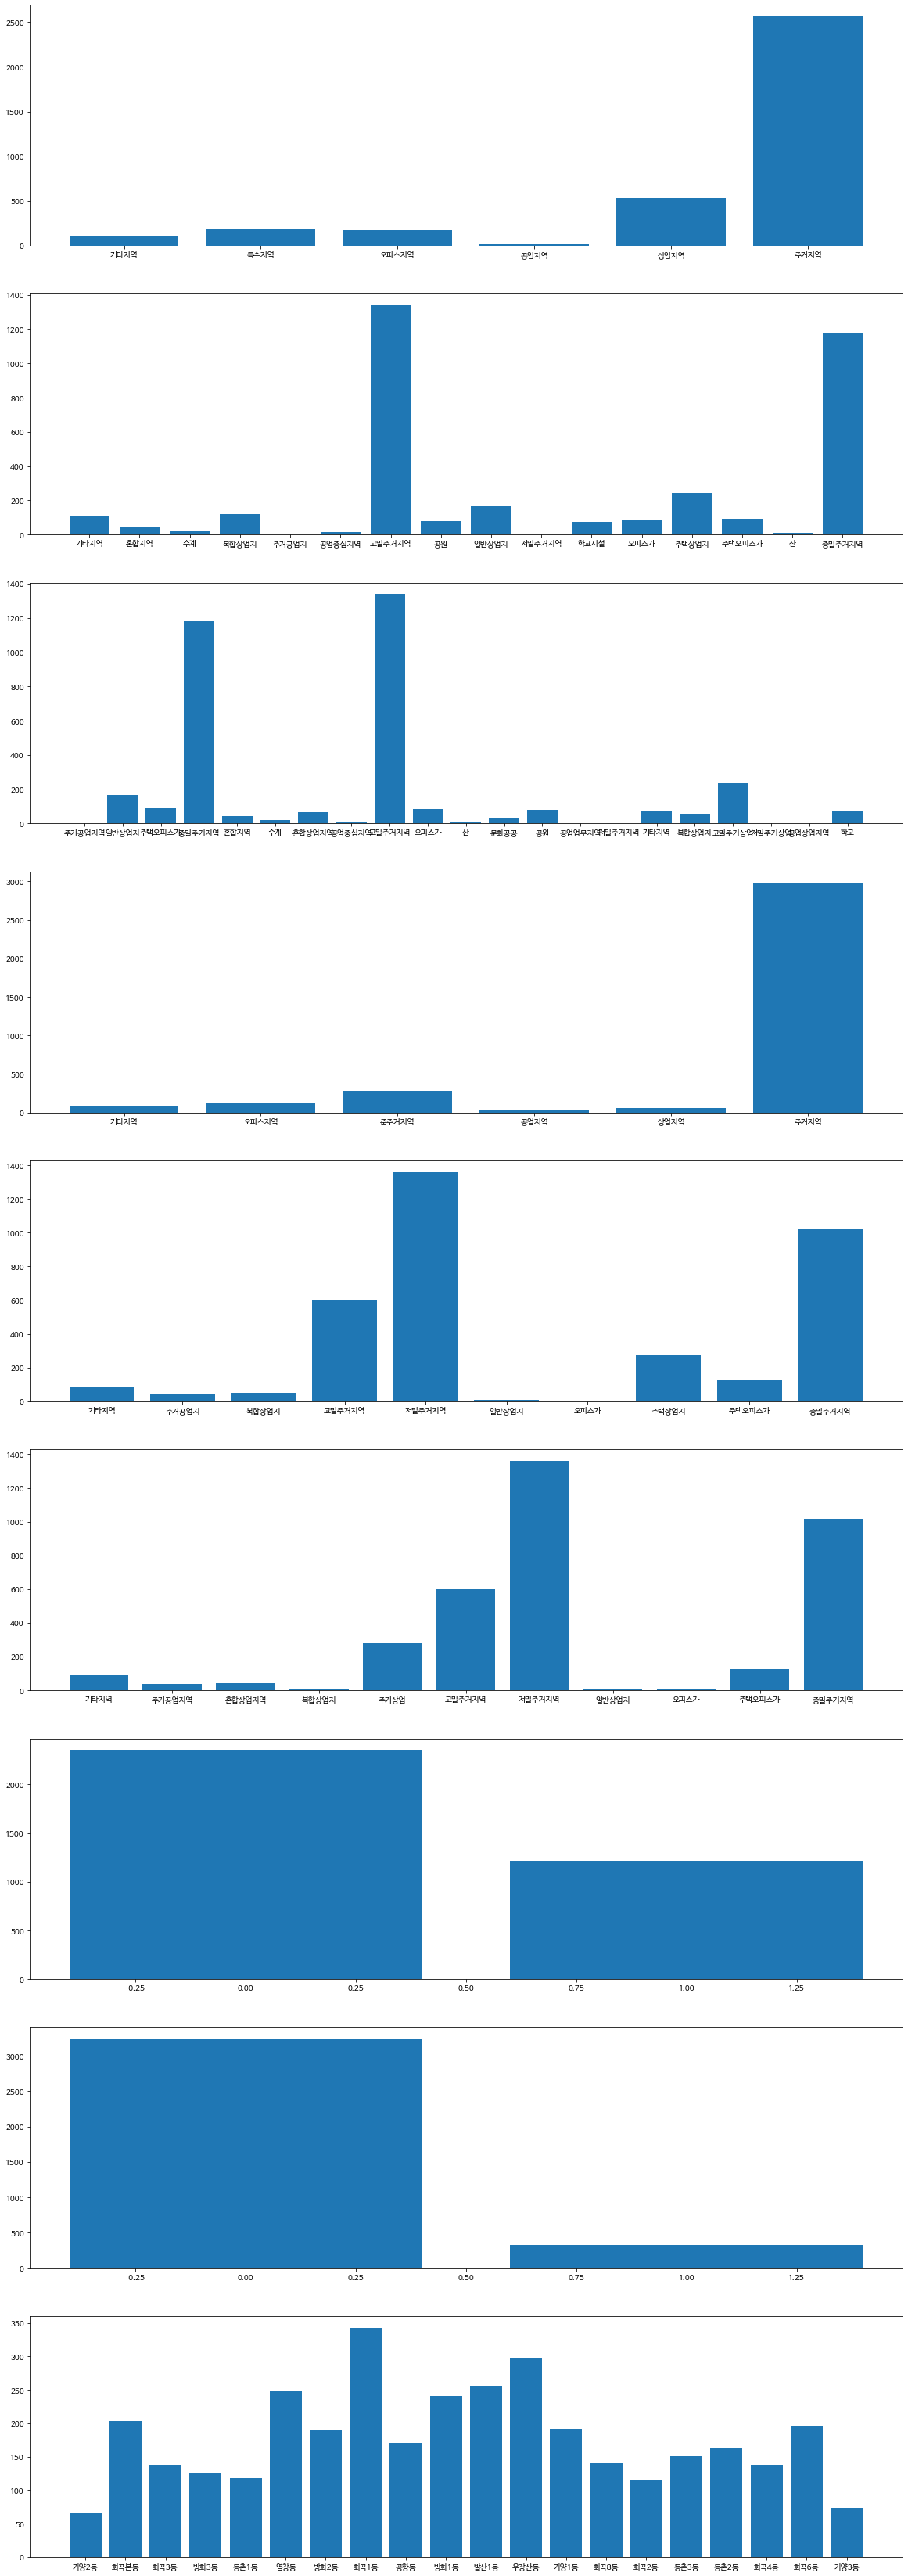

In [13]:
# 기준별 개수 확인
plt.figure(figsize=(20, 60))
cols = gs_st.columns[:9]
for i in range(len(cols)):
  ctg = list(set(gs_st[cols[i]]))
  cnt = []
  for j in ctg:
    cnt.append(list(gs_st[cols[i]]).count(j))
  plt.subplot(9, 1, i+1) 
  plt.bar(ctg, cnt)

In [8]:
# 블록유형_중분류를 기준으로 one-hot encoding
dng = list(set(gs_st['동']))
ctg = list(set(gs_st['블록유형_중분류']))
cnts = [] # 동별로 중분류기준에 대한 count 삽입

def mid_cnt(dong):
  new_df = gs_st[gs_st['동']==dong]
  cnt = []
  for i in ctg:
    cnt.append(new_df['블록유형_중분류'].tolist().count(i))
  cnts.append(cnt)

for i in dng:  mid_cnt(i)

In [9]:
new_gs_st = pd.DataFrame({"DNG":dng})
for i in range(len(ctg)):
  new_gs_st[ctg[i]] = np.array(cnts)[:,i]
new_gs_st

,DNG,기타지역,혼합지역,수계,복합상업지,주거공업지,공업중심지역,고밀주거지역,공원,일반상업지,저밀주거지역,학교시설,오피스가,주택상업지,주택오피스가,산,중밀주거지역
0,가양2동,1,0,2,1,0,0,49,4,3,0,3,1,2,1,0,0
1,화곡본동,3,5,0,4,0,0,17,3,4,0,2,2,17,5,0,142
2,화곡3동,0,0,0,5,0,0,70,1,3,0,0,3,9,5,0,42
3,방화3동,4,1,1,1,0,0,71,9,7,0,5,2,5,0,2,17
4,등촌1동,1,2,1,10,1,0,46,1,15,0,1,7,9,4,0,20
5,염창동,7,0,2,7,0,3,153,1,23,0,5,13,12,3,0,19
6,방화2동,8,3,0,9,0,1,40,0,4,0,3,5,21,13,2,82
7,화곡1동,1,7,1,15,0,0,92,1,14,0,3,3,39,14,0,153
8,공항동,8,1,1,7,1,0,20,1,11,0,5,1,14,4,0,97
9,방화1동,8,6,3,9,0,0,103,2,12,1,5,5,24,13,0,50


In [ ]:
new_gs_st.to_csv('/content/drive/Shareddrives/강서구/using_data/상권세분화.csv', index=False)

### 3. 행정동별 공동주택 데이터

In [ ]:
house = pd.read_excel("/content/drive/Shareddrives/강서구/220319 MakeDF/data/서울특별시_공공주택.xls", header=2)
house = house[house['자치구']=='강서구'].reset_index(drop=True).drop([0], axis=0).drop(['기간', '자치구', '합계', '계'], axis=1)
for i in house.columns[1:]:
  house[i] = np.where(house[i]=='X', 0, house[i]).astype('int')
house

,동,단독주택,다가구주택,영업겸용,아파트,연립주택,다세대주택,비거주용건물내주택
1,염창동,9,43,34,11882,216,1015,49
2,등촌1동,16,109,58,4633,143,1382,43
3,등촌2동,60,352,79,2717,472,3291,38
4,등촌3동,0,0,6,13287,0,211,14
5,화곡본동,120,456,154,1064,630,10103,78
6,화곡2동,54,488,119,338,96,4930,68
7,화곡3동,24,370,84,3463,108,2580,36
8,화곡4동,60,587,184,694,179,5270,79
9,화곡6동,44,391,125,3117,692,3641,75
10,화곡8동,71,448,133,734,329,7273,47


In [ ]:
house.to_csv('/content/drive/Shareddrives/강서구/using_data/공동주택.csv', index=False)